In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from taskdataset import TaskDataset
import matplotlib.pyplot as plt
import os

In [31]:
os.chdir(os.getcwd())
print(os.getcwd())

c:\Users\Krzysztof\Desktop\ensembleAI-ScoutTeam


20000
6021
<class 'list'>
AxesImage(shape=(32, 32))
55364435
101031


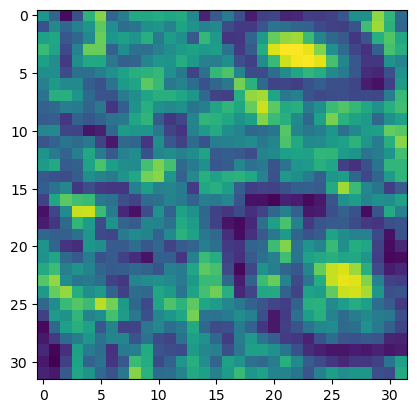

In [32]:
index = 103
print(len(dataset))
print(dataset.ids[index])
print(type(dataset.ids))
print(plt.imshow(np.asarray(dataset.imgs[index])))
print(dataset.labels[index])
print(dataset.ids[0])


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        return x

In [ ]:
l1_penalty = l1_weight * sum([p.abs().sum() for p in net.hidden.parameters()])